In [1]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
plt.gray()

<Figure size 432x288 with 0 Axes>

In [2]:
import sys
sys.path.append('..')

In [3]:
full_archive = np.load('../data_folder/ct/full_archive.npz', allow_pickle = True)

In [4]:
input_images = full_archive["image"]

In [5]:
import prox_tv
from skimage.transform import radon, iradon, iradon_sart
from PIL import Image, ImageDraw

def get_mask(size):
    mask = Image.new('L', size, 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((-1, -1) + size, fill=1)
    mask = np.array(mask)
    return mask

def make_window(img, a, b):
    assert(a < b)
    img = np.minimum(255, np.maximum(0, (img - a) / (b - a) * 255))
    return img

def make_fbp(img, size):
    img = np.array(img)
    theta = np.linspace(0., 360., size, endpoint=False)
    sino = radon(img, theta=theta, circle=True)
    return iradon(sino, theta=theta, circle=True)

img = make_window(input_images[0], -1024, 1024)
fbp = make_fbp(img, 64)
tv1 = prox_tv.tv1_2d(fbp, 0.1)

/home/urota/anaconda3/envs/py27/lib/python2.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/urota/anaconda3/envs/py27/lib/python2.7/site-packages/skimage/transform/radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


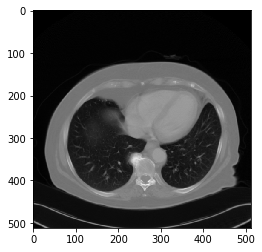

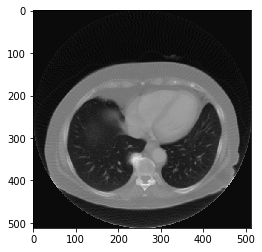

In [62]:
img = make_window(input_images[20], -1024, 1024)
plt.imshow(img)
plt.show()
fbp = make_fbp(img, )
plt.imshow(fbp)
plt.show()

In [6]:
import skimage.measure

def normalize(src):
    mi = np.min(src)
    ma = np.max(src)
    return (src - mi) / (ma - mi)

def compare(src, result, sum_, i, size, name):
    psnr = skimage.measure.compare_psnr(src, result)
    ssim = skimage.measure.compare_ssim(src, result)
    with open(name, "a") as f:
        f.write("{}, {}, {}, {}\n".format(i, size, psnr, ssim))
    sum_[0] += psnr
    sum_[1] += ssim

In [ ]:
sum_fbp = {64:[0., 0.], 128:[0., 0.], 256:[0., 0.], 512:[0., 0.]}
sum_sart = {64:[0, 0], 128:[0, 0], 256:[0, 0], 512:[0, 0]}
sum_tv1 = {64:[0, 0], 128:[0, 0], 256:[0, 0], 512:[0, 0]}

for i, img in enumerate(input_images):
    print("step {}".format(i))
    if img.shape != (512, 512):
        continue
    img = make_window(img, -1024, 1024)
    img = normalize(img * get_mask(img.shape))
    for size in [64, 128, 256, 512]:
        print("size {}".format(size), end="\r")
        theta = np.linspace(0., 360., size, endpoint=False)
        sino = radon(img, theta=theta, circle=True)
        fbp = iradon(sino, theta=theta, circle=True)
        sart = iradon_sart(sino, theta=theta)
        tv1 = prox_tv.tv1_2d(fbp, 0.1)
        compare(img, fbp, sum_fbp[size], i, size, "fbp.csv")
        compare(img, sart, sum_sart[size], i, size, "sart.csv")
        compare(img, tv1, sum_tv1[size], i, size, "tv1.csv")
    for target in [[sum_fbp, "FBP"], [sum_sart, "SART"], [sum_tv1, "TV1"]]:
        for j in sorted(target[0].keys()):
            print("{}-{} PSNR:{} SSIM:{}".format(target[1], j, target[0][j][0] / (i+1), target[0][j][1] / (i+1)))

In [120]:
import csv

elapsed_time:6.53675293922[sec]
elapsed_time:6.53967118263[sec]
elapsed_time:6.75564599037[sec]
elapsed_time:6.75224089622[sec]
elapsed_time:7.1355638504[sec]
elapsed_time:7.23739099503[sec]
elapsed_time:8.06123399734[sec]
elapsed_time:8.16097903252[sec]

speed = {"fbp.csv":{64:"{\\bf0.21}", 128:"0.41", 256:"0.82", 512:"1.71"},
         "sart.csv":{64:"16.79", 128:"8.30", 256:"4.11", 512:"2.07"},
         "tv1.csv":{64:"0.21", 128:"1.01", 256:"1.49", 512:"2.31"},
         "fbp-unet64.csv":{64:"6.54(1.02)", 128:"6.76(1.26)", 256:"7.14(1.72)", 512:"8.06(2.70)"},
         "fbp-unet512.csv":{64:"6.54(1.04)", 128:"6.75(1.26)", 256:"7.24(1.72)", 512:"8.16(2.70)"}}

def show_hist(filename):
    with open(filename, "r") as f:
        data = csv.reader(f)
        psnr = {64:[], 128:[], 256:[], 512:[]}
        ssim = {64:[], 128:[], 256:[], 512:[]}
        for line in data:
            psnr[int(line[1])].append(float(line[2]))
            ssim[int(line[1])].append(float(line[3]))

        def show_ave_hist(array):
            print("ave hist")
            hist = []
            for i in range(1000):
                c = np.random.choice(array, 10)
                hist.append(np.average(c))
            plt.hist(hist)
            plt.show()
        """
        print(filename)
        print("psnr")
        for i in psnr:
            print(i)
            plt.hist(psnr[i])
            plt.show()
        print("ssim")
        for i in ssim:
            print(i)
            plt.hist(ssim[i])
            plt.show()
            show_ave_hist(ssim[i])
        """
        from scipy import stats
        def calc_statistics(dic):
            for i in reversed(dic.keys()):
                print("{} mean:{} sem:{}".format(i, np.average(dic[i]), stats.sem(dic[i])))
        print("{} {}".format(filename, "psnr"))
        calc_statistics(psnr)
        print("{} {}".format(filename, "ssim"))
        calc_statistics(ssim)

        print("{}".format(filename))
        for i in reversed(psnr.keys()):
            print("    & {} & ".format(i), end="")
            print("\\begin{tabular}{c} \\textcolor{red}{%.2f} \\\\ \\textcolor{red}{(%.2f)} \\end{tabular} & " % (np.average(psnr[i]),
                                                                                                                   stats.sem(psnr[i])),
                                                                                                                   end="")
            print("\\begin{tabular}{c} \\textcolor{red}{%.3f} \\\\ \\textcolor{red}{(%.4f)} \\end{tabular} & " % (np.average(ssim[i]),
                                                                                                                   stats.sem(ssim[i])),
                                                                                                                   end="")
            print("%s \\\\ \\cline{2-5}"%speed[filename][i])
        print("")

show_hist("fbp.csv")
show_hist("sart.csv")
show_hist("tv1.csv")
show_hist("fbp-unet64.csv")
show_hist("fbp-unet512.csv")

fbp.csv psnr
512 mean:35.1727284208 sem:0.185717989944
256 mean:31.9323983847 sem:0.163267001644
128 mean:26.5553743634 sem:0.132594687843
64 mean:21.4089456051 sem:0.114265396397
fbp.csv ssim
512 mean:0.960920899416 sem:0.00126131016341
256 mean:0.901101166244 sem:0.00266291056254
128 mean:0.73417330902 sem:0.00401303483945
64 mean:0.547047025481 sem:0.0040235963837
fbp.csv
    & 512 & \begin{tabular}{c} \textcolor{red}{35.17} \\ \textcolor{red}{(0.19)} \end{tabular} & \begin{tabular}{c} \textcolor{red}{0.961} \\ \textcolor{red}{(0.0013)} \end{tabular} & 1.71 \\ \cline{2-5}
    & 256 & \begin{tabular}{c} \textcolor{red}{31.93} \\ \textcolor{red}{(0.16)} \end{tabular} & \begin{tabular}{c} \textcolor{red}{0.901} \\ \textcolor{red}{(0.0027)} \end{tabular} & 0.82 \\ \cline{2-5}
    & 128 & \begin{tabular}{c} \textcolor{red}{26.56} \\ \textcolor{red}{(0.13)} \end{tabular} & \begin{tabular}{c} \textcolor{red}{0.734} \\ \textcolor{red}{(0.0040)} \end{tabular} & 0.41 \\ \cline{2-5}
    & 64 &

W0928 15:49:16.402123 140689522496896 deprecation_wrapper.py:119] From ../tf_unet/unet.py:193: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0928 15:49:16.404845 140689522496896 deprecation_wrapper.py:119] From ../tf_unet/unet.py:198: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0928 15:49:16.430932 140689522496896 deprecation_wrapper.py:119] From ../tf_unet/layers.py:25: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0928 15:49:16.447864 140689522496896 deprecation.py:506] From ../tf_unet/layers.py:39: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0928 15:49:16.466954 140689522496896 deprecation_wrapper.py:119] From ../tf_unet/layers.py:48: The name tf.nn.

Tensor("output_map/conv2d/dropout/mul_1:0", shape=(?, ?, ?, 1), dtype=float32)
Tensor("preprocessing/Reshape:0", shape=(?, ?, ?, 1), dtype=float32)


W0928 15:49:17.355496 140689522496896 deprecation_wrapper.py:119] From ../tf_unet/unet.py:165: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.

W0928 15:49:17.706044 140689522496896 deprecation_wrapper.py:119] From ../tf_unet/layers.py:68: The name tf.log is deprecated. Please use tf.math.log instead.

W0928 15:49:18.359586 140689522496896 deprecation_wrapper.py:119] From ../tf_unet/unet.py:274: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.



-127.01941350390757 321.89525658976004
(1, 512, 512, 1)
-127.01941350390757 321.89525658976004


W0928 15:49:18.621119 140689522496896 deprecation_wrapper.py:119] From ../tf_unet/unet.py:307: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0928 15:49:18.658628 140689522496896 deprecation.py:323] From /home/urota/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


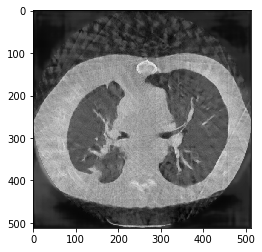

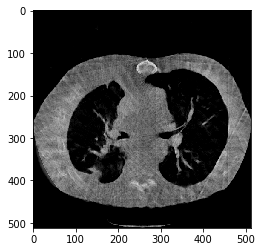

elapsed_time:6.53675293922[sec]
elapsed_time:6.53967118263[sec]
elapsed_time:6.75564599037[sec]
elapsed_time:6.75224089622[sec]
elapsed_time:7.1355638504[sec]
elapsed_time:7.23739099503[sec]
elapsed_time:8.06123399734[sec]
elapsed_time:8.16097903252[sec]


In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

from tf_unet import unet
net = unet.Unet(channels=1, n_class=1, cost="euclidean", layers=5, features_root=32)
img = input_images[0]
img = make_window(img, -1024, 1024)
img = img * get_mask(img.shape)
theta = np.linspace(0., 360., 64, endpoint=False)
sino = radon(img, theta=theta, circle=True)
fbp = iradon(sino, theta=theta, circle=True)
print(np.min(fbp), np.max(fbp))
x_test = fbp.reshape(1, 512, 512, 1)
print(x_test.shape)
print(np.min(x_test), np.max(x_test))
prediction = net.predict("./unet_trained64/model.ckpt", x_test).reshape(512, 512)
plt.imshow(prediction)
plt.show()
n = normalize(np.where(prediction < 0, 0, prediction))
plt.imshow(n)
plt.show()

import time
def calc_time(size, model_size):
    theta = np.linspace(0., 360., size, endpoint=False)
    sino = radon(img, theta=theta, circle=True)
    import tensorflow as tf
    config = tf.ConfigProto(device_count = {'GPU': 0})
    
    start = time.time()
    fbp = iradon(sino, theta=theta, circle=True)
    prediction = net.predict("./unet_trained{}/model.ckpt".format(model_size), x_test, config).reshape(512, 512)
    elapsed_time = time.time() - start
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

for size in [64, 128, 256, 512]:
    calc_time(size, 64)
    calc_time(size, 512)

In [92]:
from tf_unet import unet
net = unet.Unet(channels=1, n_class=1, cost="euclidean", layers=5, features_root=32)

sum_fbp_unet64 = {64:[0., 0.], 128:[0., 0.], 256:[0., 0.], 512:[0., 0.]}
sum_fbp_unet512 = {64:[0., 0.], 128:[0., 0.], 256:[0., 0.], 512:[0., 0.]}
sum_stacked_unet = {64:[0., 0.], 128:[0., 0.], 256:[0., 0.], 512:[0., 0.]}

for i, img in enumerate(input_images):
    print("step {}".format(i))
    if img.shape != (512, 512):
        continue
    img = make_window(img, -1024, 1024)
    img = img * get_mask(img.shape)
    for size in [64, 128, 256, 512]:
        print("size {}".format(size), end="\r")
        theta = np.linspace(0., 360., size, endpoint=False)
        sino = radon(img, theta=theta, circle=True)
        fbp = iradon(sino, theta=theta, circle=True)
        x_test = fbp.reshape(1, 512, 512, 1)
        fbp_unet64 = net.predict("./unet_trained64/model.ckpt", x_test).reshape(512, 512)
        fbp_unet512 = net.predict("./unet_trained512/model.ckpt", x_test).reshape(512, 512)
        #stacked_unet = 
        compare(normalize(img), normalize(np.where(fbp_unet64 < 0, 0, fbp_unet64)), sum_fbp_unet64[size], i, size, "fbp-unet64.csv")
        compare(normalize(img), normalize(np.where(fbp_unet512 < 0, 0, fbp_unet512)), sum_fbp_unet512[size], i, size, "fbp-unet512.csv")
        """
        plt.imshow(img)
        plt.show()
        plt.imshow(fbp_unet64)
        plt.show()
        plt.imshow(fbp_unet512)
        plt.show()
        """
        #compare(img, stacked_unet, sum_stacked_unet[size], i, size, "stacked_unet.csv")
    for target in [[sum_fbp_unet64, "FBP-U-Net64"], [sum_fbp_unet512, "FBP-U-Net512"]]:
        for j in sorted(target[0].keys()):
            print("{}-{} PSNR:{} SSIM:{}".format(target[1], j, target[0][j][0] / (i+1), target[0][j][1] / (i+1)))

Tensor("output_map/conv2d/dropout/mul_1:0", shape=(?, ?, ?, 1), dtype=float32)
Tensor("preprocessing/Reshape:0", shape=(?, ?, ?, 1), dtype=float32)
step 0
FBP-U-Net64-64 PSNR:21.8159864491 SSIM:0.618815927601
FBP-U-Net64-128 PSNR:23.0363357473 SSIM:0.663867051865
FBP-U-Net64-256 PSNR:22.2194338823 SSIM:0.687494656143
FBP-U-Net64-512 PSNR:22.3030976921 SSIM:0.699333978499
FBP-U-Net512-64 PSNR:18.299087847 SSIM:0.505045217283
FBP-U-Net512-128 PSNR:20.7751201802 SSIM:0.602825502787
FBP-U-Net512-256 PSNR:23.4091346683 SSIM:0.739466445382
FBP-U-Net512-512 PSNR:25.1122644153 SSIM:0.826993673832
step 1
FBP-U-Net64-64 PSNR:22.3559828881 SSIM:0.65311863824
FBP-U-Net64-128 PSNR:22.4266264844 SSIM:0.695154961226
FBP-U-Net64-256 PSNR:21.9546670708 SSIM:0.714435192621
FBP-U-Net64-512 PSNR:22.1348291598 SSIM:0.721647593319
FBP-U-Net512-64 PSNR:20.0767223462 SSIM:0.566902713239
FBP-U-Net512-128 PSNR:22.8168780117 SSIM:0.69509077696
FBP-U-Net512-256 PSNR:25.3014667327 SSIM:0.799341392618
FBP-U-Net512-

FBP-U-Net64-64 PSNR:22.7560226652 SSIM:0.684773410353
FBP-U-Net64-128 PSNR:22.790209777 SSIM:0.726006002229
FBP-U-Net64-256 PSNR:22.5567213266 SSIM:0.738939906496
FBP-U-Net64-512 PSNR:22.6890233178 SSIM:0.743996152632
FBP-U-Net512-64 PSNR:20.6227409958 SSIM:0.608952635208
FBP-U-Net512-128 PSNR:23.3158653012 SSIM:0.73548326968
FBP-U-Net512-256 PSNR:25.2051803071 SSIM:0.832055503412
FBP-U-Net512-512 PSNR:26.0485929192 SSIM:0.872349306177
step 19
FBP-U-Net64-64 PSNR:22.69876816 SSIM:0.680585423996
FBP-U-Net64-128 PSNR:22.7519393018 SSIM:0.720706115832
FBP-U-Net64-256 PSNR:22.5266548828 SSIM:0.732833934718
FBP-U-Net64-512 PSNR:22.6523015958 SSIM:0.737589032419
FBP-U-Net512-64 PSNR:20.674106578 SSIM:0.614217946133
FBP-U-Net512-128 PSNR:23.20938615 SSIM:0.741190602551
FBP-U-Net512-256 PSNR:25.0162424575 SSIM:0.835184397407
FBP-U-Net512-512 PSNR:25.8282268544 SSIM:0.873976696576
step 20
FBP-U-Net64-64 PSNR:22.6682584021 SSIM:0.683155447345
FBP-U-Net64-128 PSNR:22.6803859502 SSIM:0.72184570396

FBP-U-Net64-64 PSNR:22.645755611 SSIM:0.67623262508
FBP-U-Net64-128 PSNR:22.6534518413 SSIM:0.713316122847
FBP-U-Net64-256 PSNR:22.5737290796 SSIM:0.724471046319
FBP-U-Net64-512 PSNR:22.6632067957 SSIM:0.728064966606
FBP-U-Net512-64 PSNR:20.863268896 SSIM:0.623227129142
FBP-U-Net512-128 PSNR:23.5848623899 SSIM:0.748633382316
FBP-U-Net512-256 PSNR:25.2418097649 SSIM:0.838396765873
FBP-U-Net512-512 PSNR:26.0357329517 SSIM:0.875023717556
step 38
FBP-U-Net64-64 PSNR:22.6171327777 SSIM:0.67417579024
FBP-U-Net64-128 PSNR:22.6070464406 SSIM:0.711243638044
FBP-U-Net64-256 PSNR:22.5272305436 SSIM:0.722347165558
FBP-U-Net64-512 PSNR:22.6131415033 SSIM:0.72588975385
FBP-U-Net512-64 PSNR:20.82202103 SSIM:0.624777259778
FBP-U-Net512-128 PSNR:23.5423710717 SSIM:0.750082884434
FBP-U-Net512-256 PSNR:25.1819068538 SSIM:0.839787667789
FBP-U-Net512-512 PSNR:25.9607740216 SSIM:0.876038134402
step 39
FBP-U-Net64-64 PSNR:22.5644762839 SSIM:0.674135547502
FBP-U-Net64-128 PSNR:22.528059346 SSIM:0.711033540777

FBP-U-Net64-64 PSNR:22.4021844576 SSIM:0.681331868416
FBP-U-Net64-128 PSNR:22.6647583921 SSIM:0.722143721072
FBP-U-Net64-256 PSNR:22.4817187251 SSIM:0.735789886108
FBP-U-Net64-512 PSNR:22.4548238654 SSIM:0.740169745812
FBP-U-Net512-64 PSNR:20.8156213347 SSIM:0.628250914411
FBP-U-Net512-128 PSNR:23.7591117123 SSIM:0.755744886863
FBP-U-Net512-256 PSNR:25.7032259231 SSIM:0.850693309243
FBP-U-Net512-512 PSNR:26.5762971714 SSIM:0.886868203166
step 57
FBP-U-Net64-64 PSNR:22.4367268214 SSIM:0.682047198076
FBP-U-Net64-128 PSNR:22.6709114875 SSIM:0.722482471584
FBP-U-Net64-256 PSNR:22.4797255648 SSIM:0.735970255186
FBP-U-Net64-512 PSNR:22.4507240122 SSIM:0.740287579616
FBP-U-Net512-64 PSNR:20.8610025984 SSIM:0.628183008866
FBP-U-Net512-128 PSNR:23.8101377038 SSIM:0.755799450091
FBP-U-Net512-256 PSNR:25.7503257488 SSIM:0.850269357608
FBP-U-Net512-512 PSNR:26.6196215509 SSIM:0.886352628098
step 58
FBP-U-Net64-64 PSNR:22.4486809935 SSIM:0.68045766711
FBP-U-Net64-128 PSNR:22.6746436953 SSIM:0.72107

FBP-U-Net64-64 PSNR:22.5746475379 SSIM:0.677305233804
FBP-U-Net64-128 PSNR:22.8374945191 SSIM:0.718310867421
FBP-U-Net64-256 PSNR:22.6914046115 SSIM:0.733078480629
FBP-U-Net64-512 PSNR:22.6946957522 SSIM:0.737942611225
FBP-U-Net512-64 PSNR:20.7194448441 SSIM:0.618412094676
FBP-U-Net512-128 PSNR:23.7578050697 SSIM:0.740885491555
FBP-U-Net512-256 PSNR:25.9491252214 SSIM:0.841180380268
FBP-U-Net512-512 PSNR:26.9793291847 SSIM:0.883232767929
step 76
FBP-U-Net64-64 PSNR:22.5844033971 SSIM:0.676918794264
FBP-U-Net64-128 PSNR:22.8338962609 SSIM:0.71764809017
FBP-U-Net64-256 PSNR:22.6967745871 SSIM:0.732238452118
FBP-U-Net64-512 PSNR:22.7030460783 SSIM:0.737019410349
FBP-U-Net512-64 PSNR:20.7602009851 SSIM:0.618628647358
FBP-U-Net512-128 PSNR:23.7968994153 SSIM:0.741110483075
FBP-U-Net512-256 PSNR:25.9707564023 SSIM:0.840737438321
FBP-U-Net512-512 PSNR:26.9980758701 SSIM:0.882739802661
step 77
FBP-U-Net64-64 PSNR:22.6050786284 SSIM:0.678621140125
FBP-U-Net64-128 PSNR:22.8669109253 SSIM:0.71924

FBP-U-Net64-64 PSNR:22.740512613 SSIM:0.671691767295
FBP-U-Net64-128 PSNR:23.0659625496 SSIM:0.712288893809
FBP-U-Net64-256 PSNR:22.9886777028 SSIM:0.726614572308
FBP-U-Net64-512 PSNR:23.0322426947 SSIM:0.731123335258
FBP-U-Net512-64 PSNR:20.7090519684 SSIM:0.612840897113
FBP-U-Net512-128 PSNR:23.7869873484 SSIM:0.734634069513
FBP-U-Net512-256 PSNR:26.027866408 SSIM:0.836833264506
FBP-U-Net512-512 PSNR:27.1037982835 SSIM:0.881127497195
step 95
FBP-U-Net64-64 PSNR:22.7746375798 SSIM:0.672706315608
FBP-U-Net64-128 PSNR:23.0967944375 SSIM:0.713248608733
FBP-U-Net64-256 PSNR:23.0202776889 SSIM:0.727501789786
FBP-U-Net64-512 PSNR:23.0632928337 SSIM:0.731969670468
FBP-U-Net512-64 PSNR:20.7488434027 SSIM:0.613438471134
FBP-U-Net512-128 PSNR:23.8404996158 SSIM:0.735497491509
FBP-U-Net512-256 PSNR:26.0674844547 SSIM:0.837183056442
FBP-U-Net512-512 PSNR:27.1427911707 SSIM:0.881180871117
step 96
FBP-U-Net64-64 PSNR:22.7694404674 SSIM:0.672680169793
FBP-U-Net64-128 PSNR:23.0802254538 SSIM:0.712965

FBP-U-Net64-64 PSNR:22.6619021924 SSIM:0.67129027897
FBP-U-Net64-128 PSNR:23.0221642449 SSIM:0.712230789964
FBP-U-Net64-256 PSNR:22.9603801011 SSIM:0.726933181032
FBP-U-Net64-512 PSNR:23.0119158754 SSIM:0.731607377077
FBP-U-Net512-64 PSNR:20.811660323 SSIM:0.61089377672
FBP-U-Net512-128 PSNR:23.911331926 SSIM:0.73462200496
FBP-U-Net512-256 PSNR:26.2279311864 SSIM:0.838260604922
FBP-U-Net512-512 PSNR:27.3600024208 SSIM:0.882006727469
step 114
FBP-U-Net64-64 PSNR:22.671992799 SSIM:0.67115861006
FBP-U-Net64-128 PSNR:23.0311770333 SSIM:0.712188606524
FBP-U-Net64-256 PSNR:22.969580798 SSIM:0.726918776079
FBP-U-Net64-512 PSNR:23.0211537519 SSIM:0.731580778833
FBP-U-Net512-64 PSNR:20.8127556183 SSIM:0.610869640878
FBP-U-Net512-128 PSNR:23.9183897461 SSIM:0.734942313172
FBP-U-Net512-256 PSNR:26.252861443 SSIM:0.83894627353
FBP-U-Net512-512 PSNR:27.3808029459 SSIM:0.882612407174
step 115
FBP-U-Net64-64 PSNR:22.6688439288 SSIM:0.671454916807
FBP-U-Net64-128 PSNR:23.0457974395 SSIM:0.712733800439

FBP-U-Net64-64 PSNR:22.5577886623 SSIM:0.662530664471
FBP-U-Net64-128 PSNR:23.0509629333 SSIM:0.704999247357
FBP-U-Net64-256 PSNR:23.0298939439 SSIM:0.720948751342
FBP-U-Net64-512 PSNR:23.0872986403 SSIM:0.726155251557
FBP-U-Net512-64 PSNR:20.5647287461 SSIM:0.602567019583
FBP-U-Net512-128 PSNR:23.6843720878 SSIM:0.72623506298
FBP-U-Net512-256 PSNR:26.0479319852 SSIM:0.835309617301
FBP-U-Net512-512 PSNR:27.199738389 SSIM:0.882341565826
step 133
FBP-U-Net64-64 PSNR:22.5616403475 SSIM:0.662882563618
FBP-U-Net64-128 PSNR:23.0571496347 SSIM:0.705453871261
FBP-U-Net64-256 PSNR:23.0379567389 SSIM:0.721508106861
FBP-U-Net64-512 PSNR:23.0963063619 SSIM:0.726778162312
FBP-U-Net512-64 PSNR:20.5545269959 SSIM:0.602057548284
FBP-U-Net512-128 PSNR:23.6800473518 SSIM:0.72581887648
FBP-U-Net512-256 PSNR:26.0617629103 SSIM:0.835044017616
FBP-U-Net512-512 PSNR:27.2197822267 SSIM:0.882245528498
step 134
FBP-U-Net64-64 PSNR:22.5679866036 SSIM:0.663088228601
FBP-U-Net64-128 PSNR:23.0471169509 SSIM:0.70550

FBP-U-Net64-64 PSNR:22.6624417299 SSIM:0.661623032454
FBP-U-Net64-128 PSNR:23.1241735841 SSIM:0.703311240292
FBP-U-Net64-256 PSNR:23.090786511 SSIM:0.718672848933
FBP-U-Net64-512 PSNR:23.1547322172 SSIM:0.723636331997
FBP-U-Net512-64 PSNR:20.5208213106 SSIM:0.598926134376
FBP-U-Net512-128 PSNR:23.6570877161 SSIM:0.72088621984
FBP-U-Net512-256 PSNR:26.0452129875 SSIM:0.830522864678
FBP-U-Net512-512 PSNR:27.1839399136 SSIM:0.878418955797
step 152
FBP-U-Net64-64 PSNR:22.6597265764 SSIM:0.661196293017
FBP-U-Net64-128 PSNR:23.1285106509 SSIM:0.702936464084
FBP-U-Net64-256 PSNR:23.0946247525 SSIM:0.718322186867
FBP-U-Net64-512 PSNR:23.158083291 SSIM:0.723284804612
FBP-U-Net512-64 PSNR:20.5068324717 SSIM:0.598221076872
FBP-U-Net512-128 PSNR:23.6383032443 SSIM:0.720077482342
FBP-U-Net512-256 PSNR:26.0283492523 SSIM:0.829867924805
FBP-U-Net512-512 PSNR:27.1710437414 SSIM:0.878083204284
step 153
FBP-U-Net64-64 PSNR:22.6685782342 SSIM:0.66177752384
FBP-U-Net64-128 PSNR:23.1412840722 SSIM:0.703219

FBP-U-Net64-64 PSNR:22.6642824434 SSIM:0.660418799175
FBP-U-Net64-128 PSNR:23.1681442932 SSIM:0.701937693323
FBP-U-Net64-256 PSNR:23.1386892256 SSIM:0.717294257433
FBP-U-Net64-512 PSNR:23.2211152726 SSIM:0.722467888491
FBP-U-Net512-64 PSNR:20.3927157726 SSIM:0.595355524719
FBP-U-Net512-128 PSNR:23.5267450611 SSIM:0.715598760923
FBP-U-Net512-256 PSNR:26.005857659 SSIM:0.826103411561
FBP-U-Net512-512 PSNR:27.2076748074 SSIM:0.875944364491
step 171
FBP-U-Net64-64 PSNR:22.672393243 SSIM:0.660260501772
FBP-U-Net64-128 PSNR:23.1681220104 SSIM:0.701733123319
FBP-U-Net64-256 PSNR:23.141806206 SSIM:0.717060978674
FBP-U-Net64-512 PSNR:23.2252141193 SSIM:0.722217485808
FBP-U-Net512-64 PSNR:20.3935360107 SSIM:0.59557564859
FBP-U-Net512-128 PSNR:23.5343529272 SSIM:0.715907511025
FBP-U-Net512-256 PSNR:26.0295983058 SSIM:0.826407739453
FBP-U-Net512-512 PSNR:27.2292527618 SSIM:0.876130176326
step 172
FBP-U-Net64-64 PSNR:22.676161766 SSIM:0.659961379658
FBP-U-Net64-128 PSNR:23.1723272698 SSIM:0.7014706

FBP-U-Net64-64 PSNR:22.7340359966 SSIM:0.659763239975
FBP-U-Net64-128 PSNR:23.2758745774 SSIM:0.7007389911
FBP-U-Net64-256 PSNR:23.2356443449 SSIM:0.7158530678
FBP-U-Net64-512 PSNR:23.31612997 SSIM:0.720866627722
FBP-U-Net512-64 PSNR:20.3781772467 SSIM:0.592755270048
FBP-U-Net512-128 PSNR:23.5247168938 SSIM:0.711254022673
FBP-U-Net512-256 PSNR:26.0444922405 SSIM:0.823142186834
FBP-U-Net512-512 PSNR:27.2546490128 SSIM:0.874669278092
step 190
FBP-U-Net64-64 PSNR:22.7369540684 SSIM:0.659956964657
FBP-U-Net64-128 PSNR:23.2755673765 SSIM:0.700905316389
FBP-U-Net64-256 PSNR:23.2312426626 SSIM:0.715959376956
FBP-U-Net64-512 PSNR:23.3126586914 SSIM:0.720936461998
FBP-U-Net512-64 PSNR:20.3665511448 SSIM:0.592427850435
FBP-U-Net512-128 PSNR:23.519874545 SSIM:0.710613746124
FBP-U-Net512-256 PSNR:26.037870104 SSIM:0.822599164511
FBP-U-Net512-512 PSNR:27.2524527188 SSIM:0.874351823337
step 191
FBP-U-Net64-64 PSNR:22.7304290952 SSIM:0.659952889033
FBP-U-Net64-128 PSNR:23.2792503963 SSIM:0.7008943479

FBP-U-Net64-64 PSNR:22.6893497201 SSIM:0.659688657286
FBP-U-Net64-128 PSNR:23.2403414436 SSIM:0.701152976728
FBP-U-Net64-256 PSNR:23.1843557603 SSIM:0.716932036469
FBP-U-Net64-512 PSNR:23.2540964101 SSIM:0.722259938186
FBP-U-Net512-64 PSNR:20.3132975511 SSIM:0.590817791157
FBP-U-Net512-128 PSNR:23.4768999219 SSIM:0.707799048386
FBP-U-Net512-256 PSNR:26.0191621998 SSIM:0.820758029827
FBP-U-Net512-512 PSNR:27.2907721746 SSIM:0.874227003828
step 209
FBP-U-Net64-64 PSNR:22.6909905045 SSIM:0.659674685033
FBP-U-Net64-128 PSNR:23.2474546195 SSIM:0.701131788653
FBP-U-Net64-256 PSNR:23.1915965686 SSIM:0.716898926099
FBP-U-Net64-512 PSNR:23.2600063825 SSIM:0.722224174247
FBP-U-Net512-64 PSNR:20.2984126152 SSIM:0.590114189776
FBP-U-Net512-128 PSNR:23.4591032504 SSIM:0.706545338276
FBP-U-Net512-256 PSNR:26.0001346663 SSIM:0.819578675143
FBP-U-Net512-512 PSNR:27.2763145666 SSIM:0.873509399511
step 210
FBP-U-Net64-64 PSNR:22.6958895225 SSIM:0.659653263088
FBP-U-Net64-128 PSNR:23.2491877684 SSIM:0.70

FBP-U-Net64-64 PSNR:22.6390691171 SSIM:0.659194832247
FBP-U-Net64-128 PSNR:23.2111754668 SSIM:0.700427038108
FBP-U-Net64-256 PSNR:23.167660715 SSIM:0.716430684766
FBP-U-Net64-512 PSNR:23.240180432 SSIM:0.721958703005
FBP-U-Net512-64 PSNR:20.1757303935 SSIM:0.588358921032
FBP-U-Net512-128 PSNR:23.3245827758 SSIM:0.702897642062
FBP-U-Net512-256 PSNR:25.9044853493 SSIM:0.816265632282
FBP-U-Net512-512 PSNR:27.2478754188 SSIM:0.871840993688
step 228
FBP-U-Net64-64 PSNR:22.6393912735 SSIM:0.659221067474
FBP-U-Net64-128 PSNR:23.2107295257 SSIM:0.700409238634
FBP-U-Net64-256 PSNR:23.1679831709 SSIM:0.716389091687
FBP-U-Net64-512 PSNR:23.2400658827 SSIM:0.721906408557
FBP-U-Net512-64 PSNR:20.1808887207 SSIM:0.588723144796
FBP-U-Net512-128 PSNR:23.3381901103 SSIM:0.703377839104
FBP-U-Net512-256 PSNR:25.9205773653 SSIM:0.816734072859
FBP-U-Net512-512 PSNR:27.261949474 SSIM:0.872141449304
step 229
FBP-U-Net64-64 PSNR:22.6132035341 SSIM:0.658428217547
FBP-U-Net64-128 PSNR:23.1907647217 SSIM:0.69970

FBP-U-Net64-64 PSNR:22.4925765817 SSIM:0.658421330381
FBP-U-Net64-128 PSNR:23.1252091981 SSIM:0.700225333239
FBP-U-Net64-256 PSNR:23.11454686 SSIM:0.717137429078
FBP-U-Net64-512 PSNR:23.1971483442 SSIM:0.72322753083
FBP-U-Net512-64 PSNR:20.0220078495 SSIM:0.586600471152
FBP-U-Net512-128 PSNR:23.1971551968 SSIM:0.700081546903
FBP-U-Net512-256 PSNR:25.7669344765 SSIM:0.813938801905
FBP-U-Net512-512 PSNR:27.1204812968 SSIM:0.870910269358
step 247
FBP-U-Net64-64 PSNR:22.4849379967 SSIM:0.658273403204
FBP-U-Net64-128 PSNR:23.1229017785 SSIM:0.700144161258
FBP-U-Net64-256 PSNR:23.1147554795 SSIM:0.717151104582
FBP-U-Net64-512 PSNR:23.1980896287 SSIM:0.72328874575
FBP-U-Net512-64 PSNR:20.0081666506 SSIM:0.586144530762
FBP-U-Net512-128 PSNR:23.1837994413 SSIM:0.699426905395
FBP-U-Net512-256 PSNR:25.7538432209 SSIM:0.813332799981
FBP-U-Net512-512 PSNR:27.1078922313 SSIM:0.870525113416
step 248
FBP-U-Net64-64 PSNR:22.4754866042 SSIM:0.658103993283
FBP-U-Net64-128 PSNR:23.1199438536 SSIM:0.700046

FBP-U-Net64-64 PSNR:22.4733178257 SSIM:0.659110370896
FBP-U-Net64-128 PSNR:23.1212933396 SSIM:0.701449128489
FBP-U-Net64-256 PSNR:23.1128668428 SSIM:0.718678632555
FBP-U-Net64-512 PSNR:23.1989521735 SSIM:0.724888698289
FBP-U-Net512-64 PSNR:20.0180354911 SSIM:0.585577207933
FBP-U-Net512-128 PSNR:23.180120429 SSIM:0.699096971334
FBP-U-Net512-256 PSNR:25.7899602104 SSIM:0.813002273745
FBP-U-Net512-512 PSNR:27.164431491 SSIM:0.870590626292
step 266
FBP-U-Net64-64 PSNR:22.4742258822 SSIM:0.659223396159
FBP-U-Net64-128 PSNR:23.118759031 SSIM:0.701472470395
FBP-U-Net64-256 PSNR:23.1089755627 SSIM:0.718663992284
FBP-U-Net64-512 PSNR:23.1944885845 SSIM:0.724854590152
FBP-U-Net512-64 PSNR:20.029998373 SSIM:0.585865955828
FBP-U-Net512-128 PSNR:23.1912006369 SSIM:0.699438651937
FBP-U-Net512-256 PSNR:25.7933870056 SSIM:0.81320104764
FBP-U-Net512-512 PSNR:27.1636360766 SSIM:0.870646984054
step 267
FBP-U-Net64-64 PSNR:22.4849284718 SSIM:0.659861110774
FBP-U-Net64-128 PSNR:23.126826043 SSIM:0.70205373

FBP-U-Net64-64 PSNR:22.3700683048 SSIM:0.659963303018
FBP-U-Net64-128 PSNR:23.0369266797 SSIM:0.701903090188
FBP-U-Net64-256 PSNR:23.0214740831 SSIM:0.718835438986
FBP-U-Net64-512 PSNR:23.0983841643 SSIM:0.72489907979
FBP-U-Net512-64 PSNR:19.9521074429 SSIM:0.585205590451
FBP-U-Net512-128 PSNR:23.1352099539 SSIM:0.69805018844
FBP-U-Net512-256 PSNR:25.7061413375 SSIM:0.810818159969
FBP-U-Net512-512 PSNR:27.0533185334 SSIM:0.867837149258
step 286
FBP-U-Net64-64 PSNR:22.3554741584 SSIM:0.660254824351
FBP-U-Net64-128 PSNR:23.037169516 SSIM:0.702247600942
FBP-U-Net64-256 PSNR:23.0236548867 SSIM:0.719213318743
FBP-U-Net64-512 PSNR:23.1007269488 SSIM:0.725283063095
FBP-U-Net512-64 PSNR:19.9342635821 SSIM:0.585354095319
FBP-U-Net512-128 PSNR:23.1281748735 SSIM:0.698241210289
FBP-U-Net512-256 PSNR:25.7144744213 SSIM:0.811086429809
FBP-U-Net512-512 PSNR:27.0610791972 SSIM:0.868119794259
step 287
FBP-U-Net64-64 PSNR:22.3501818758 SSIM:0.660093144933
FBP-U-Net64-128 PSNR:23.0375854007 SSIM:0.70211

FBP-U-Net64-64 PSNR:22.2876232815 SSIM:0.660163251823
FBP-U-Net64-128 PSNR:23.0376484425 SSIM:0.70273357446
FBP-U-Net64-256 PSNR:23.0557437333 SSIM:0.720096566489
FBP-U-Net64-512 PSNR:23.136904417 SSIM:0.726349597393
FBP-U-Net512-64 PSNR:19.8105589296 SSIM:0.583563821729
FBP-U-Net512-128 PSNR:23.0445839079 SSIM:0.695135010898
FBP-U-Net512-256 PSNR:25.6374717384 SSIM:0.808781039307
FBP-U-Net512-512 PSNR:27.0404908533 SSIM:0.867135552684
step 305
FBP-U-Net64-64 PSNR:22.2896665898 SSIM:0.660109425845
FBP-U-Net64-128 PSNR:23.0345977162 SSIM:0.702631673802
FBP-U-Net64-256 PSNR:23.0537296603 SSIM:0.719963493025
FBP-U-Net64-512 PSNR:23.1348493272 SSIM:0.726200806602
FBP-U-Net512-64 PSNR:19.81614115 SSIM:0.583927876287
FBP-U-Net512-128 PSNR:23.0499847901 SSIM:0.69556337331
FBP-U-Net512-256 PSNR:25.6478905932 SSIM:0.809115430603
FBP-U-Net512-512 PSNR:27.0468626946 SSIM:0.867373095121
step 306
FBP-U-Net64-64 PSNR:22.2920172808 SSIM:0.660048699974
FBP-U-Net64-128 PSNR:23.0341116025 SSIM:0.7025532

FBP-U-Net64-64 PSNR:22.2485999266 SSIM:0.658191234842
FBP-U-Net64-128 PSNR:23.0255622741 SSIM:0.700563264933
FBP-U-Net64-256 PSNR:23.0415549429 SSIM:0.717945106171
FBP-U-Net64-512 PSNR:23.1318043556 SSIM:0.724324679529
FBP-U-Net512-64 PSNR:19.728804681 SSIM:0.579679414524
FBP-U-Net512-128 PSNR:22.9366487273 SSIM:0.689776333954
FBP-U-Net512-256 PSNR:25.5374606312 SSIM:0.803560106222
FBP-U-Net512-512 PSNR:26.9728823571 SSIM:0.863820254816
step 324
FBP-U-Net64-64 PSNR:22.2453829113 SSIM:0.658073827629
FBP-U-Net64-128 PSNR:23.0121264367 SSIM:0.700472644549
FBP-U-Net64-256 PSNR:23.025557846 SSIM:0.717869687205
FBP-U-Net64-512 PSNR:23.1152584867 SSIM:0.724265315939
FBP-U-Net512-64 PSNR:19.7270967435 SSIM:0.579559123002
FBP-U-Net512-128 PSNR:22.9303904551 SSIM:0.689778650368
FBP-U-Net512-256 PSNR:25.531303419 SSIM:0.803633567171
FBP-U-Net512-512 PSNR:26.9640635397 SSIM:0.863896066609
step 325
FBP-U-Net64-64 PSNR:22.243649635 SSIM:0.657948812399
FBP-U-Net64-128 PSNR:23.0049949626 SSIM:0.700399

FBP-U-Net64-64 PSNR:22.0255035433 SSIM:0.651401298353
FBP-U-Net64-128 PSNR:22.7601224319 SSIM:0.693003423371
FBP-U-Net64-256 PSNR:22.7550851918 SSIM:0.71011375817
FBP-U-Net64-512 PSNR:22.84526635 SSIM:0.716417008361
FBP-U-Net512-64 PSNR:19.4992375986 SSIM:0.571404846229
FBP-U-Net512-128 PSNR:22.6574740852 SSIM:0.67971670581
FBP-U-Net512-256 PSNR:25.2417802138 SSIM:0.792465022499
FBP-U-Net512-512 PSNR:26.6718114655 SSIM:0.852506288823
step 347
FBP-U-Net64-64 PSNR:22.0211275353 SSIM:0.651207784169
FBP-U-Net64-128 PSNR:22.7607887754 SSIM:0.692923688918
FBP-U-Net64-256 PSNR:22.7574324965 SSIM:0.71014084799
FBP-U-Net64-512 PSNR:22.8482788111 SSIM:0.716482111338
FBP-U-Net512-64 PSNR:19.4909955443 SSIM:0.571285293938
FBP-U-Net512-128 PSNR:22.6526398979 SSIM:0.679564299691
FBP-U-Net512-256 PSNR:25.2419815009 SSIM:0.792447070708
FBP-U-Net512-512 PSNR:26.6756937954 SSIM:0.852652605749
step 348
FBP-U-Net64-64 PSNR:22.0307341765 SSIM:0.651798107517
FBP-U-Net64-128 PSNR:22.7699509308 SSIM:0.6935105

FBP-U-Net64-64 PSNR:22.0021919974 SSIM:0.652984857338
FBP-U-Net64-128 PSNR:22.7533265601 SSIM:0.694699500592
FBP-U-Net64-256 PSNR:22.7443688946 SSIM:0.712031440148
FBP-U-Net64-512 PSNR:22.8370279094 SSIM:0.718434292503
FBP-U-Net512-64 PSNR:19.4904176149 SSIM:0.572514486359
FBP-U-Net512-128 PSNR:22.6428154823 SSIM:0.679949246466
FBP-U-Net512-256 PSNR:25.1662743675 SSIM:0.791526830337
FBP-U-Net512-512 PSNR:26.5785245765 SSIM:0.85147283504
step 366
FBP-U-Net64-64 PSNR:22.0000578183 SSIM:0.653076371327
FBP-U-Net64-128 PSNR:22.7475842505 SSIM:0.694809051847
FBP-U-Net64-256 PSNR:22.73691663 SSIM:0.712135118557
FBP-U-Net64-512 PSNR:22.8289753696 SSIM:0.71853612244
FBP-U-Net512-64 PSNR:19.4988658135 SSIM:0.572661026312
FBP-U-Net512-128 PSNR:22.6509018282 SSIM:0.680105640791
FBP-U-Net512-256 PSNR:25.1709429762 SSIM:0.791625850076
FBP-U-Net512-512 PSNR:26.5818908041 SSIM:0.851528182779
step 367
FBP-U-Net64-64 PSNR:21.9933020656 SSIM:0.653206899117
FBP-U-Net64-128 PSNR:22.7376609691 SSIM:0.694968

FBP-U-Net64-64 PSNR:21.9406673224 SSIM:0.654471360681
FBP-U-Net64-128 PSNR:22.7157631631 SSIM:0.696555617027
FBP-U-Net64-256 PSNR:22.7089684714 SSIM:0.714150035651
FBP-U-Net64-512 PSNR:22.8068895604 SSIM:0.720686657753
FBP-U-Net512-64 PSNR:19.4943318166 SSIM:0.572738993076
FBP-U-Net512-128 PSNR:22.648128154 SSIM:0.679584881556
FBP-U-Net512-256 PSNR:25.1285940082 SSIM:0.790345205954
FBP-U-Net512-512 PSNR:26.5271680596 SSIM:0.850464248083
step 385
FBP-U-Net64-64 PSNR:21.9418498065 SSIM:0.654781048894
FBP-U-Net64-128 PSNR:22.7210841388 SSIM:0.696924946354
FBP-U-Net64-256 PSNR:22.7155054004 SSIM:0.71456611928
FBP-U-Net64-512 PSNR:22.8135815105 SSIM:0.721122754454
FBP-U-Net512-64 PSNR:19.4944512134 SSIM:0.572907443486
FBP-U-Net512-128 PSNR:22.6533968938 SSIM:0.679795708549
FBP-U-Net512-256 PSNR:25.1381429909 SSIM:0.790626212151
FBP-U-Net512-512 PSNR:26.5381919716 SSIM:0.850716504664
step 386
FBP-U-Net64-64 PSNR:21.9530204257 SSIM:0.655008862668
FBP-U-Net64-128 PSNR:22.7167703928 SSIM:0.6970

FBP-U-Net64-64 PSNR:21.872424172 SSIM:0.653672190332
FBP-U-Net64-128 PSNR:22.6164294411 SSIM:0.695379925585
FBP-U-Net64-256 PSNR:22.6107663075 SSIM:0.71290606247
FBP-U-Net64-512 PSNR:22.7115160871 SSIM:0.719483176364
FBP-U-Net512-64 PSNR:19.4363465683 SSIM:0.571484484859
FBP-U-Net512-128 PSNR:22.5670017523 SSIM:0.676843227647
FBP-U-Net512-256 PSNR:25.0440117999 SSIM:0.786414017071
FBP-U-Net512-512 PSNR:26.4401849473 SSIM:0.845790538229
step 406
step 407
FBP-U-Net64-64 PSNR:21.8291667749 SSIM:0.652473635004
FBP-U-Net64-128 PSNR:22.5711976991 SSIM:0.694050453599
FBP-U-Net64-256 PSNR:22.5660402351 SSIM:0.711533642818
FBP-U-Net64-512 PSNR:22.6663852411 SSIM:0.718086461894
FBP-U-Net512-64 PSNR:19.3926588147 SSIM:0.570456883029
FBP-U-Net512-128 PSNR:22.5177297926 SSIM:0.675507068842
FBP-U-Net512-256 PSNR:24.9897395293 SSIM:0.784684800639
FBP-U-Net512-512 PSNR:26.3807578754 SSIM:0.843831953982
step 408
FBP-U-Net64-64 PSNR:21.8359134151 SSIM:0.652591136801
FBP-U-Net64-128 PSNR:22.579044361 SSI

FBP-U-Net64-64 PSNR:21.8517831382 SSIM:0.653859793532
FBP-U-Net64-128 PSNR:22.5783437416 SSIM:0.69526375018
FBP-U-Net64-256 PSNR:22.5689267576 SSIM:0.712590757664
FBP-U-Net64-512 PSNR:22.669355687 SSIM:0.719119640509
FBP-U-Net512-64 PSNR:19.4491544698 SSIM:0.572098172004
FBP-U-Net512-128 PSNR:22.5613859075 SSIM:0.677049784231
FBP-U-Net512-256 PSNR:25.0143962429 SSIM:0.785741422774
FBP-U-Net512-512 PSNR:26.3896083591 SSIM:0.844380548677
step 426
FBP-U-Net64-64 PSNR:21.8433572816 SSIM:0.653601734
FBP-U-Net64-128 PSNR:22.5743814259 SSIM:0.695077711182
FBP-U-Net64-256 PSNR:22.5670503098 SSIM:0.712498053476
FBP-U-Net64-512 PSNR:22.6677717763 SSIM:0.719086529077
FBP-U-Net512-64 PSNR:19.4401371002 SSIM:0.571843777036
FBP-U-Net512-128 PSNR:22.552634882 SSIM:0.676722609023
FBP-U-Net512-256 PSNR:25.0057549941 SSIM:0.785481105052
FBP-U-Net512-512 PSNR:26.3876649409 SSIM:0.844305905442
step 427
FBP-U-Net64-64 PSNR:21.8477145237 SSIM:0.653869479458
FBP-U-Net64-128 PSNR:22.5739959293 SSIM:0.69533573

FBP-U-Net64-64 PSNR:21.894556036 SSIM:0.655010207055
FBP-U-Net64-128 PSNR:22.6073458492 SSIM:0.696154680564
FBP-U-Net64-256 PSNR:22.5934290853 SSIM:0.713371644845
FBP-U-Net64-512 PSNR:22.6947775699 SSIM:0.719868491201
FBP-U-Net512-64 PSNR:19.4689449681 SSIM:0.57206082535
FBP-U-Net512-128 PSNR:22.5664720046 SSIM:0.676568135835
FBP-U-Net512-256 PSNR:24.9913725232 SSIM:0.785095826704
FBP-U-Net512-512 PSNR:26.3701871549 SSIM:0.843750165065
step 445
FBP-U-Net64-64 PSNR:21.8976127431 SSIM:0.655151575519
FBP-U-Net64-128 PSNR:22.6114984406 SSIM:0.696267033569
FBP-U-Net64-256 PSNR:22.5978796295 SSIM:0.713468910079
FBP-U-Net64-512 PSNR:22.7000217091 SSIM:0.719962014746
FBP-U-Net512-64 PSNR:19.4713910217 SSIM:0.572035336406
FBP-U-Net512-128 PSNR:22.5668354318 SSIM:0.676351809278
FBP-U-Net512-256 PSNR:24.9923396341 SSIM:0.784995433702
FBP-U-Net512-512 PSNR:26.3725704184 SSIM:0.843703814847
step 446
FBP-U-Net64-64 PSNR:21.9088235766 SSIM:0.655398045079
FBP-U-Net64-128 PSNR:22.6233309022 SSIM:0.6964

FBP-U-Net64-64 PSNR:21.9212279175 SSIM:0.655526708335
FBP-U-Net64-128 PSNR:22.6355866623 SSIM:0.696722017117
FBP-U-Net64-256 PSNR:22.6349579769 SSIM:0.713894316071
FBP-U-Net64-512 PSNR:22.7371629414 SSIM:0.720378820762
FBP-U-Net512-64 PSNR:19.4772619042 SSIM:0.570355340459
FBP-U-Net512-128 PSNR:22.5516473786 SSIM:0.674675330013
FBP-U-Net512-256 PSNR:24.9550140445 SSIM:0.782955025497
FBP-U-Net512-512 PSNR:26.3307482781 SSIM:0.841972194156
step 464
FBP-U-Net64-64 PSNR:21.9143315991 SSIM:0.655321444034
FBP-U-Net64-128 PSNR:22.6299796906 SSIM:0.696526323589
FBP-U-Net64-256 PSNR:22.6314985727 SSIM:0.71369763602
FBP-U-Net64-512 PSNR:22.7385988263 SSIM:0.720264494281
FBP-U-Net512-64 PSNR:19.4685937067 SSIM:0.570000709303
FBP-U-Net512-128 PSNR:22.5419445834 SSIM:0.674192241804
FBP-U-Net512-256 PSNR:24.9440254437 SSIM:0.782440410829
FBP-U-Net512-512 PSNR:26.3199505559 SSIM:0.841537338828
step 465
FBP-U-Net64-64 PSNR:21.9012569442 SSIM:0.655221791823
FBP-U-Net64-128 PSNR:22.6234314585 SSIM:0.696

Tensor("output_map/conv2d/dropout/mul_1:0", shape=(?, ?, ?, 1), dtype=float32)
Tensor("preprocessing/Reshape:0", shape=(?, ?, ?, 1), dtype=float32)
step 0


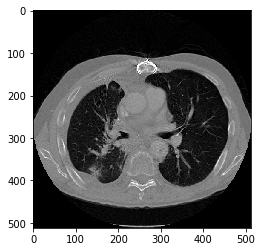

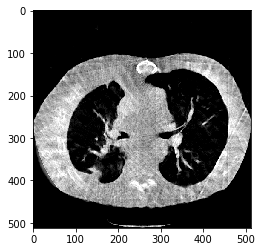

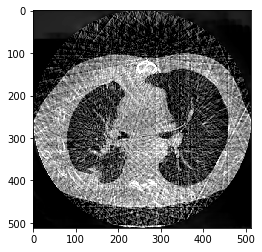

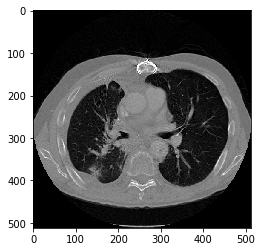

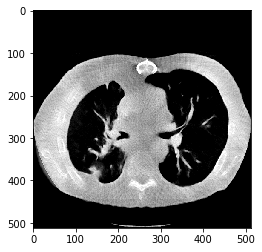

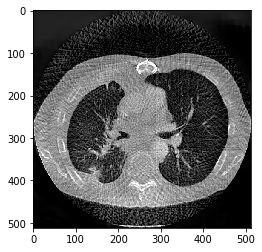

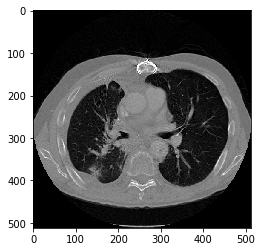

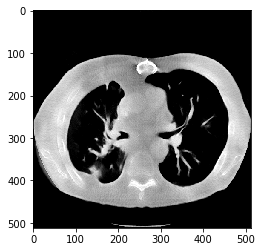

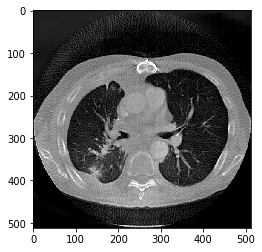

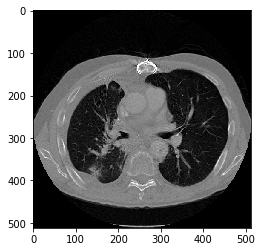

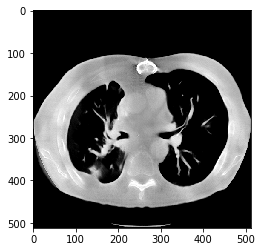

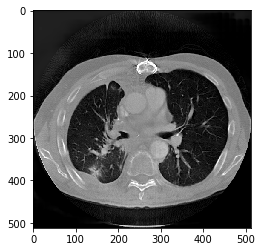

FBP-U-Net64-64 PSNR:16.9093744049 SSIM:0.568242334578
FBP-U-Net64-128 PSNR:16.1542683405 SSIM:0.624592276021
FBP-U-Net64-256 PSNR:16.2488145517 SSIM:0.662384415395
FBP-U-Net64-512 PSNR:16.4192445809 SSIM:0.679801110225
FBP-U-Net512-64 PSNR:15.8386379948 SSIM:0.362825140492
FBP-U-Net512-128 PSNR:19.3107732581 SSIM:0.500168389219
FBP-U-Net512-256 PSNR:22.000969559 SSIM:0.688512477986
FBP-U-Net512-512 PSNR:24.2409031788 SSIM:0.812155694671


In [99]:
from tf_unet import unet
net = unet.Unet(channels=1, n_class=1, cost="euclidean", layers=5, features_root=32)

sum_fbp_unet64 = {64:[0., 0.], 128:[0., 0.], 256:[0., 0.], 512:[0., 0.]}
sum_fbp_unet512 = {64:[0., 0.], 128:[0., 0.], 256:[0., 0.], 512:[0., 0.]}
sum_stacked_unet = {64:[0., 0.], 128:[0., 0.], 256:[0., 0.], 512:[0., 0.]}

for i, img in enumerate(input_images):
    print("step {}".format(i))
    if img.shape != (512, 512):
        continue
    img = make_window(img, -1024, 1024)
    img = img * get_mask(img.shape)
    for size in [64, 128, 256, 512]:
        print("size {}".format(size), end="\r")
        theta = np.linspace(0., 360., size, endpoint=False)
        sino = radon(img, theta=theta, circle=True)
        fbp = iradon(sino, theta=theta, circle=True)
        x_test = fbp.reshape(1, 512, 512, 1)
        fbp_unet64 = net.predict("./unet_trained64/model.ckpt", x_test).reshape(512, 512)
        fbp_unet512 = net.predict("./unet_trained512/model.ckpt", x_test).reshape(512, 512)
        
        fbp_unet64 = np.where(fbp_unet64 < 0, 0, fbp_unet64)
        fbp_unet64 = np.where(fbp_unet64 > 255, 255, fbp_unet64)
        
        fbp_unet512 = np.where(fbp_unet512 < 0, 0, fbp_unet512)
        fbp_unet512 = np.where(fbp_unet512 > 255, 255, fbp_unet512)
        compare(normalize(img), normalize(fbp_unet64), sum_fbp_unet64[size], i, size, "fbp-unet64_.csv")
        compare(normalize(img), normalize(fbp_unet512), sum_fbp_unet512[size], i, size, "fbp-unet512_.csv")
        plt.imshow(img)
        plt.show()
        plt.imshow(fbp_unet64)
        plt.show()
        plt.imshow(fbp_unet512)
        plt.show()
    for target in [[sum_fbp_unet64, "FBP-U-Net64"], [sum_fbp_unet512, "FBP-U-Net512"]]:
        for j in sorted(target[0].keys()):
            print("{}-{} PSNR:{} SSIM:{}".format(target[1], j, target[0][j][0] / (i+1), target[0][j][1] / (i+1)))
    break